# DEEP Q-LEARNING FOR EPIDEMIC MITIGATION
Mini-project 1 - Artificial Neural Network and Reinforcement Learning - EPFL, Spring 2023 


Maxence Hofer,
Giacomo Mossinelli 

## Initialization

In [2]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque
from itertools import count
import random

%matplotlib inline

In [3]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
#print(dyn.cities)
#dyn.draw_map()

In [ ]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

## Q1. Behaviour of the model when epidemics are unmitigated

### point 1. plot of the five variables

In [ ]:
"""Loading the environment"""
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

action = { # DO NOTHING
    'confinement': False, 
    'isolation': False, 
    'hospital': False, 
    'vaccinate': False,
}

seed = 0

log = []
finished = False
obs, info = env.reset(seed)
for t in range(30):
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

fig, ax = plt.subplots(figsize=(15, 10))
[ax.plot(y) if key != "initial_population" else None for key, y in total.items()]
ax.legend(total.keys())
ax.set_title('unmitigated epidemics - TOTAL -')
ax.set_ylabel('number of people in each state')
ax.set_xlabel('time')



In [ ]:
fig, ax = plt.subplots(figsize=(15,10))


[ax.plot(y) for key, y in total.items() if key in ["infected", "dead"]]

ax.legend(["infected", "dead"])
ax.set_title('unmitigated epidemics - TOTAL -')
ax.set_ylabel('number of people in each state')
ax.set_xlabel('time')

In [ ]:
fig, axs = plt.subplots(len(cities), 1, figsize=(14, 20))
for i, (city, data) in enumerate(cities.items()):
    axs[i].plot(data['infected'])
    axs[i].plot(data['dead'])
    axs[i].legend(['infected','dead'])
    axs[i].set_title(city)
    axs[i].set_ylabel('Population')
    axs[i].set_xlabel('Time (in weeks)')
plt.tight_layout()
plt.show()

## Q2. Russo's Policy

In [18]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [19]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )
env_russo = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )


In [20]:
class Russo(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.counter=0
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,env):
        # This should be called when the environment is reset
        self.env=env
        self.counter=0
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        # reset
        if self.counter==4:
            self.counter=0
            
        if self.counter==0:
            if info.total.infected>20000:
                self.counter=1
                return 1
            else:
                return 0
        else:
            self.counter+=1
            return 1

## Point 2a

In [ ]:
agent = Russo(env)

log = []
finished = False
seed = 1
obs, info = env.reset(seed) 
agent.reset(env)
agent.epsilon = 0

week=0 # debugging purpose
while not finished:
  week=week+1
  action=agent.act(info)
    
  print("week: ",week-1)
  print("chosen action:", action)
  print("nb. of infected:", info.total.infected)
  obs, R, finished, info = env.step(action)
  log.append(info) # save the information dict for logging
  if finished:
    break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}



In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

### plot of the variables 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
[ax.plot(y) if key != "initial_population" else None for key, y in total.items()]
ax.legend(total.keys())
ax.set_title('Russo - TOTAL -')
ax.set_ylabel('number of people in each state')
ax.set_xlabel('time')

### Plot of variables i and d

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))


[ax.plot(y) for key, y in total.items() if key in ["infected", "dead"]]

ax.legend(["infected", "dead"])
ax.set_title('Russo - TOTAL -')
ax.set_ylabel('number of people in each state')
ax.set_xlabel('time')

### Plot of variable i and d for each city

In [ ]:
fig, axs = plt.subplots(len(cities), 1, figsize=(14, 20))
for i, (city, data) in enumerate(cities.items()):
    axs[i].plot(data['infected'])
    axs[i].plot(data['dead'])
    axs[i].legend(['infected','dead'])
    axs[i].set_title(city)
    axs[i].set_ylabel('Population')
    axs[i].set_xlabel('Time (in weeks)')
plt.tight_layout()
plt.show()

### Plot of the action space

In [ ]:
fig, ax = plt.subplots(figsize=(40, 10))
ax.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax.set_title('Actions')
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(list(actions.keys()))
ax.set_xlabel('time (in weeks)')

## Point 2b.

In [ ]:
agent = Russo(env) # definition of the policy


# EVALUATION PROCEDURE 

N= 50
total_confinement=np.zeros(N)
rewards=np.zeros(N)
deaths=np.zeros(N)
seed=0
for n in range(N):
    
    finished = False
    obs, info = env.reset(seed)
    agent.reset(env)
    
    seed+=1
    agent.epsilon = 0

 
    while not finished:
        
        action=agent.act(info)
    
        obs, r, finished, info = env.step(action)
        if info.action["confinement"]==1:
            total_confinement[n]+=7
        
        rewards[n]+=r
        
    deaths[n]=info.total.dead        
    
    

In [ ]:
print(info.action["confinement"])

In [ ]:
""" Plot"""
fig, ax = plt.subplots(3,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 40
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'rewards')
hist_avg(ax[2], total_confinement,'days')
fig.tight_layout()
plt.show()

"""Print"""
print(f'Average death number: {np.mean(deaths)}')
print(f'Average reward: {np.mean(rewards)}')
print(f'Average number of isolation days: {np.mean(total_confinement)}')

## Q3. A Deep Q-learning approach


In [21]:
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1, #to check
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


SCALE = 1
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 1/4)
    dead = SCALE * np.power(np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 1/4)
    #confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)


env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )
env_DQN = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [22]:
import matplotlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

episode_deaths = []

def plot_deaths(show_result=False):
    plt.figure(1)
    deaths = torch.tensor(episode_deaths, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Deaths')
    plt.plot(deaths.numpy())
    # Take 100 episode averages and plot them too
    if len(deaths) >= 100:
        means = deaths.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())  

cpu


In [23]:
BATCH_SIZE = 2048
GAMMA = 0.9
EPS_START = 0.7
EPS_END = 0.7
EPS_DECAY = 1000
TAU = 1
LR = 5e-3

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    


class DQN_1(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_1, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)




In [24]:
class Deep_Q(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                n_observations,
                n_actions,
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.env = env
        self.policy_network=DQN_1(n_observations, n_actions)
        self.target_network=DQN_1(n_observations, n_actions)
        self.policy_network.to(device)
        self.target_network.to(device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(20000)
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.policy_network.load_state_dict(torch.load(savepath+'model_policy_weights.pth'))
        self.target_network.load_state_dict(torch.load(savepath+'model_target_weights.pth'))
        

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.policy_network.state_dict(), savepath+'model_policy_weights.pth')
        torch.save(self.target_network.state_dict(), savepath+'model_target_weights.pth')

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        global seed
        if len(self.memory) < BATCH_SIZE:
            return
        seed=seed+1
        random.seed(seed)
        transitions = self.memory.sample(BATCH_SIZE)
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        #print()
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        non_final_next_states = torch.reshape(non_final_next_states, (int(np.prod(np.shape(non_final_next_states))/self.n_observations), self.n_observations))
        state_batch = torch.reshape(torch.cat(batch.state), (BATCH_SIZE, self.n_observations))
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        #print(np.shape(policy_net(state_batch)))
        #print(action_batch)
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()
        return 0
    

    def init_weights(self, m):
        if type(m) == nn.Linear:
            m.weight.fill_(1.0)
    
    def reset(self, env):
        self.env = env
        self.memory = ReplayMemory(20000)
        self.policy_network=DQN_1(self.n_observations, self.n_actions).to(device)
        self.init_weights(self.policy_network)
        self.target_network=DQN_1(self.n_observations, self.n_actions).to(device)
        self.init_weights(self.target_network)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=LR, amsgrad=True)
        return 0
    
    def act(self, state, epsilon):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        global steps_done
        global seed
        state = torch.flatten(state)
        seed=seed+1
        random.seed(seed)
        np.random.seed(seed)
        sample = random.random()
        steps_done += 1
        if sample > epsilon:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                #print(policy_net(state))
                return self.policy_network(state).argmax().view(1, 1)
        else:
            seed=seed+1
            random.seed(seed)
            env.action_space.seed(seed)
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## Points 3a. and 3b.

### ATTENTION! Remember to change uncomment the epsilon that you want to use (epsilon=0.7 or epsilon = np.maximum(0.7*(500-i_episode-1)/500, 0.2)) 

In [ ]:
seed=0
# Get number of actions from gym action space
n_actions = 2
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))


num_episodes = 500
training_trace = np.zeros((num_episodes, 3))
evaluation_trace = np.zeros((int(num_episodes/50), 3))


seed = seed+1
random.seed(seed)
np.random.seed(seed)

seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
agent = Deep_Q(env, n_observations, n_actions)

#agent.save_model("initial")

episode_deaths = []

for n in range(3):
    seed=seed+1
    env.reset(seed)
    seed=seed+1
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    seed=seed+1
    agent.reset(env)
    #agent.load_model("initial")
    #agent = Deep_Q(env, n_observations, n_actions)
    
    k=0

    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        seed = seed+1
        state, info = env.reset(seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        c_r=0
        
        ## !! Choose epsilon as prefered !!
        #epsilon = 0.7
        epsilon = np.maximum(0.7*(500-i_episode-1)/500, 0.2)
        str_epsilon = "Var" # Var or Cst
        
        steps_done=0
        #print(seed)
        for t in count():
            seed = seed+1
            np.random.seed(seed)
            action = agent.act(state, epsilon)
            observation, reward, done, infos = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            agent.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            agent.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            if done and (i_episode+1)%5==0: 
                target_net_state_dict = agent.target_network.state_dict()
                policy_net_state_dict = agent.policy_network.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                agent.target_network.load_state_dict(target_net_state_dict)
            c_r = c_r + reward[0]
            if done:
                episode_deaths.append(infos.total.dead)
                plot_deaths()
                training_trace[i_episode, n] = c_r
                break
            
        if (i_episode+1)%50==0:
            cum_rew = 0
            tmp_seed=seed
            seed=0
            for n_episode in range(20):
                seed=seed+1
                state, info = env.reset(seed)
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                cu = 0
                epsilon = 0
                steps_done=0
                for t in count():
                    np.random.seed(seed)
                    action = agent.act(state, epsilon)
                    observation, reward, done, infos = env.step(action.item())
                    reward = torch.tensor([reward], device=device)

                    if done:
                        next_state = None
                    else:
                        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                    
                    # Move to the next state
                    state = next_state
                    cu = cu + reward[0] 
                    if done:
                        cum_rew = cum_rew+cu
                        break
            evaluation_trace[k, n]=cum_rew/20
            k=k+1
            seed=tmp_seed
    agent.save_model("3"+str_epsilon+str(n))
                

        


print('Complete')
plot_deaths(show_result=True)
plt.ioff()
plt.show()

### Training trace and eval trace

In [ ]:
plt.figure(2)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Evaluation reward')
plt.plot(np.linspace(50, 500, len(evaluation_trace)), np.mean(evaluation_trace, axis=1))


plt.figure(3)
plt.title('Training trace')
plt.xlabel('Episode')
plt.ylabel('Training reward')
plt.scatter(range(500), np.mean(training_trace, axis=1))


plt.show()
print(evaluation_trace)


### Saving

In [ ]:
## To run to save training and evalutation trace with epsilon constant
evaluation_trace_3a = evaluation_trace
training_trace_3a = training_trace

np.savetxt("ev_trace_3a.csv", evaluation_trace_3a, delimiter=",")
np.savetxt("tr_trace_3a.csv", training_trace_3a, delimiter=",")


In [ ]:
## To run to save training and evalutation trace with epsilon varying
evaluation_trace_3b = evaluation_trace
training_trace_3b = training_trace

np.savetxt("ev_trace_3b.csv", evaluation_trace_3b, delimiter=",")
np.savetxt("tr_trace_3b.csv", training_trace_3b, delimiter=",")


### Comparison results point 3a. and 3b.

In [ ]:
evaluation_trace_3a = np.loadtxt("ev_trace_3a.csv", delimiter=",")
training_trace_3a = np.loadtxt("tr_trace_3a.csv", delimiter=",")

evaluation_trace_3b = np.loadtxt("ev_trace_3b.csv", delimiter=",")
training_trace_3b = np.loadtxt("tr_trace_3b.csv", delimiter=",")

plt.figure(2)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Evaluation reward')
plt.plot(np.linspace(50, 500, len(evaluation_trace_3a)), np.mean(evaluation_trace_3a, axis=1), label="$\epsilon$ constant")
plt.plot(np.linspace(50, 500, len(evaluation_trace_3b)), np.mean(evaluation_trace_3b, axis=1), label="$\epsilon$ varying")
plt.legend()

plt.figure(3)
plt.title('Training trace')
plt.xlabel('Episode')
plt.ylabel('Training reward')
plt.scatter(range(500), training_trace_3a[:, 0], c='b', label="$\epsilon$ constant")
plt.scatter(range(500), training_trace_3a[:, 1], c='b')
plt.scatter(range(500), training_trace_3a[:, 2], c='b')
plt.scatter(range(500), training_trace_3b[:, 0], c='r', label="$\epsilon$ varying")
plt.scatter(range(500), training_trace_3b[:, 1], c='r')
plt.scatter(range(500), training_trace_3b[:, 2], c='r')
plt.legend()


plt.show()

### Plot of an episode

In [ ]:
seed=0 # change the seed to get another episode
# Get number of actions from gym action space
n_actions = 2
# Get the number of state observations
seed=seed+1
obs, info = env.reset(seed)
n_observations = np.prod(np.shape(obs))
agent2 = Deep_Q(env, n_observations, n_actions)
str_epsilon="Cst"
agent2.load_model("3" + str_epsilon+"0")

seed = seed+1
random.seed(seed)

log=[]

finished =False
#obs, info = env.reset(seed)
seed+=1
epsilon = 0    
steps_done=0
while not finished:
    action = agent2.act(obs, epsilon)
    obs, r, finished, info = env.step(action.item())
    log.append(info)

        
    
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

In [ ]:
from matplotlib.ticker import MultipleLocator
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

### Point 3c. Evaluation procedure

In [ ]:
seed=0
# Get number of actions from gym action space
n_actions = 2
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))
agent2 = Deep_Q(env, n_observations, n_actions)
str_epsilon="Cst"
agent2.load_model("3" + str_epsilon+"0")

seed = seed+1
random.seed(seed)



# EVALUATION PROCEDURE 
N= 50
total_confinement=np.zeros(N)
rewards=np.zeros(N)
deaths=np.zeros(N)
seed=0


for n in range(N):
    finished =False
    obs, info = env.reset(seed)
    seed+=1
    
    epsilon = 0    # agent-epsilon 
    steps_done=0
    while not finished:
        action = agent2.act(obs, epsilon)
        obs, r, finished, info = env.step(action.item())        
    
        # collect confine days
        if info.action["confinement"]==1:
            total_confinement[n]+=7
        # collect rewards
        rewards[n]+= r
        
    
    # collect deaths
    deaths[n]=info.total.dead 
    

### histograms

In [ ]:
""" Plot"""
fig, ax = plt.subplots(3,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 40
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'rewards')
hist_avg(ax[2], total_confinement,'days')
fig.tight_layout()
plt.show()

"""Print"""
print(f'Average death number: {np.mean(deaths)}')
print(f'Average rewards: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(total_confinement)}')

## Q4.

### Point 4.1. Toggle-action-space multi-action agent

In [26]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


SCALE = 1
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    action = dyn.get_action()
    
    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
    elif a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 1/4)
    dead = SCALE * np.power(np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 1/4)
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolation = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    vaccinate = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))
    hospital = np.ones_like(dead)*int((dyn.get_action()['hospital']))

    return torch.Tensor(np.stack((infected, dead, confined, isolation, vaccinate, hospital))).unsqueeze(0)


env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

env_toggle = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [27]:
import matplotlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

episode_deaths = []

def plot_deaths(show_result=False):
    plt.figure(1)
    deaths = torch.tensor(episode_deaths, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Deaths')
    plt.plot(deaths.numpy())
    # Take 100 episode averages and plot them too
    if len(deaths) >= 100:
        means = deaths.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())  

cpu


In [29]:
BATCH_SIZE = 2048
GAMMA = 0.9
EPS_START = 0.7
EPS_END = 0.7
EPS_DECAY = 1000
TAU = 1
LR = 1e-3

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN_2(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_2, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)




In [30]:
class Deep_Q_Toggle(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                n_observations,
                n_actions,
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.env = env
        self.policy_network=DQN_2(n_observations, n_actions)
        self.target_network=DQN_2(n_observations, n_actions)
        self.policy_network.to(device)
        self.target_network.to(device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(20000)
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.policy_network.load_state_dict(torch.load(savepath+'model_policy_weights.pth'))
        self.target_network.load_state_dict(torch.load(savepath+'model_target_weights.pth'))
        

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.policy_network.state_dict(), savepath+'model_policy_weights.pth')
        torch.save(self.target_network.state_dict(), savepath+'model_target_weights.pth')

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        global seed
        if len(self.memory) < BATCH_SIZE:
            return
        seed=seed+1
        random.seed(seed)
        transitions = self.memory.sample(BATCH_SIZE)
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        #print()
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        non_final_next_states = torch.reshape(non_final_next_states, (int(np.prod(np.shape(non_final_next_states))/self.n_observations), self.n_observations))
        #print(np.shape(batch.state))
        #print(np.shape(batch.action))
        batch_state = torch.zeros(BATCH_SIZE, self.n_observations)
        for i in range(BATCH_SIZE):
            batch_state[i, :]=torch.flatten(batch.state[i])
        state_batch = np.reshape(batch_state, (BATCH_SIZE, self.n_observations))
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        #print(np.shape(policy_net(state_batch)))
        #print(action_batch)
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()
        return 0
    

    def init_weights(self, m):
        if type(m) == nn.Linear:
            m.weight.fill_(1.0)
    
    def reset(self, env):
        # This should be called when the environment is reset
        self.env = env
        self.memory = ReplayMemory(20000)
        self.policy_network=DQN_2(self.n_observations, self.n_actions).to(device)
        self.init_weights(self.policy_network)
        self.target_network=DQN_2(self.n_observations, self.n_actions).to(device)
        self.init_weights(self.target_network)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=LR, amsgrad=True)
        return 0
    
    def act(self, state, epsilon):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        global steps_done
        global seed
        state = torch.flatten(state)
        seed=seed+1
        random.seed(seed)
        sample = random.random() # TODO: Add seed
        steps_done += 1
        if sample > epsilon:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                #print(policy_net(state))
                return self.policy_network(state).argmax().view(1, 1)
        else:
            seed=seed+1
            random.seed(seed)
            env.action_space.seed(seed)
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

### Point 4.1.b

/tmp/ipykernel_1165/5814774.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
/tmp/ipykernel_1165/5814774.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
/tmp/ipykernel_1165/5814774.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


Complete


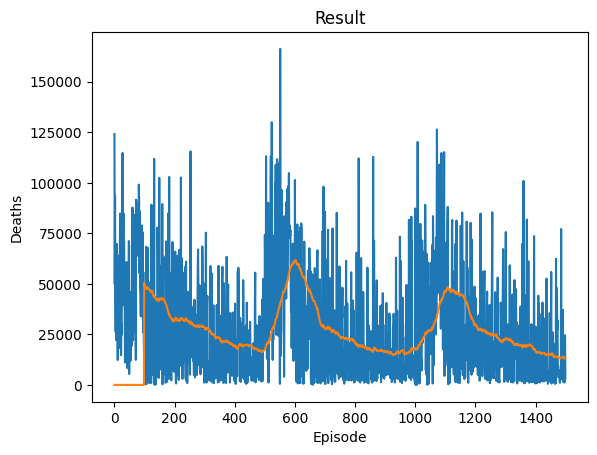

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [38]:
seed=0
# Get number of actions from gym action space
n_actions = 5
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))
np.random.seed()


num_episodes = 500
training_trace = np.zeros((num_episodes, 3))
evaluation_trace = np.zeros((int(num_episodes/50), 3))


seed = seed+1
random.seed(seed)
np.random.seed(seed)

seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
agent = Deep_Q_Toggle(env, n_observations, n_actions)

#agent.save_model("initial")

episode_deaths = []

for n in range(3):
    seed = seed+1
    env.reset(seed)
    seed=seed+1
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    agent.reset(env)
    #agent.load_model("initial")
    #agent = Deep_Q_Toggle(env, n_observations, n_actions)
    
    k=0

    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        seed = seed+1
        state, info = env.reset(seed)
        #obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        #state = observation_preprocessor(obs, dyn)
        c_r=0
        ## For this point, epsilon is varying
        epsilon = np.maximum(0.7*(500-i_episode-1)/500, 0.2)
        str_epsilon = "Var"
        steps_done=0
        for t in count():
            action = agent.act(state, epsilon)
            observation, reward, done, infos = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            agent.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            agent.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            if done and (i_episode+1)%5==0:
                target_net_state_dict = agent.target_network.state_dict()
                policy_net_state_dict = agent.policy_network.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                agent.target_network.load_state_dict(target_net_state_dict)
            
            c_r = c_r + reward[0]
            if done:
                episode_deaths.append(infos.total.dead)
                #plot_deaths()
                training_trace[i_episode, n] = c_r
                break
            
        if (i_episode+1)%50==0:
            cum_rew = 0
            tmp_seed=seed
            seed=0
            
            for n_episode in range(20):
                seed=seed+1
                state, info = env.reset(seed)
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                cu = 0
                epsilon = 0
                steps_done=0
                for t in count():
                    action = agent.act(state, epsilon)
                    observation, reward, done, infos = env.step(action.item())
                    reward = torch.tensor([reward], device=device)

                    if done:
                        next_state = None
                    else:
                        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                    # Store the transition in memory
                    #memory.push(state, action, next_state, reward)

                    # Move to the next state
                    state = next_state
                    cu = cu + reward[0] 
                    if done:
                        cum_rew = cum_rew+cu
                        break
            seed=tmp_seed
            evaluation_trace[k, n]=cum_rew/20
            k=k+1
    agent.save_model("4"+str_epsilon+str(n))
                

        


print('Complete')
plot_deaths(show_result=True)
plt.ioff()
plt.show()

### Evaluation and training traces

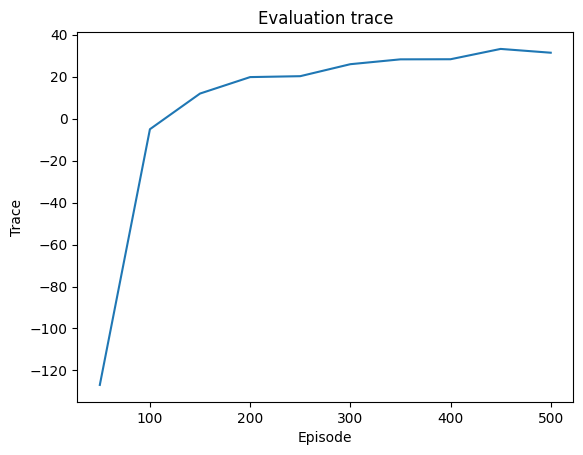

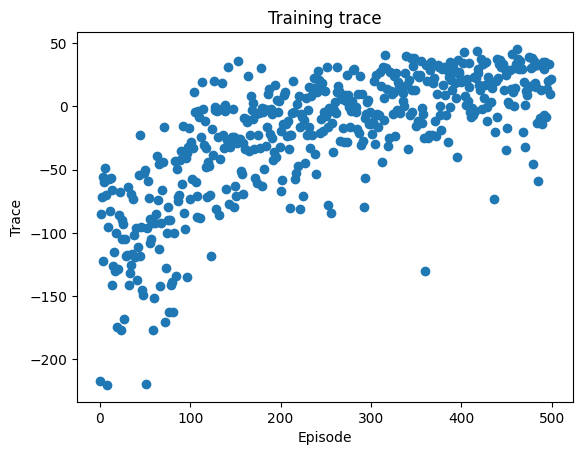

[[-125.59507751 -180.81204224  -74.28408813]
 [  -2.14880753    4.92083359  -17.84764671]
 [  13.77682209    7.00968313   15.12884045]
 [  13.22052479   19.8471241    26.38383102]
 [  12.68173027   22.20731163   25.8625145 ]
 [  24.24047661   25.37681961   28.27311707]
 [  27.78962326   26.20463562   30.8310585 ]
 [  33.42040634   21.62575722   29.92678833]
 [  35.55622864   32.27243805   31.9012394 ]
 [  35.94054413   26.30907249   32.05367279]]


In [39]:
plt.figure(4)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Trace')
plt.plot(np.linspace(50, 500, len(evaluation_trace)), np.mean(evaluation_trace, axis=1))


plt.figure(5)
plt.title('Training trace')
plt.xlabel('Episode')
plt.ylabel('Trace')
plt.scatter(range(500), np.mean(training_trace, axis=1))



plt.show()
print(evaluation_trace)

### Saving

In [40]:
evaluation_trace_41 = evaluation_trace
training_trace_41 = training_trace

np.savetxt("ev_trace_41.csv", evaluation_trace_41, delimiter=",")
np.savetxt("tr_trace_41.csv", training_trace_41, delimiter=",")


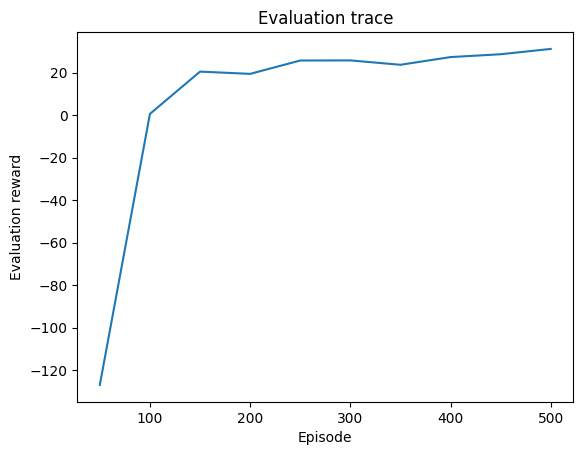

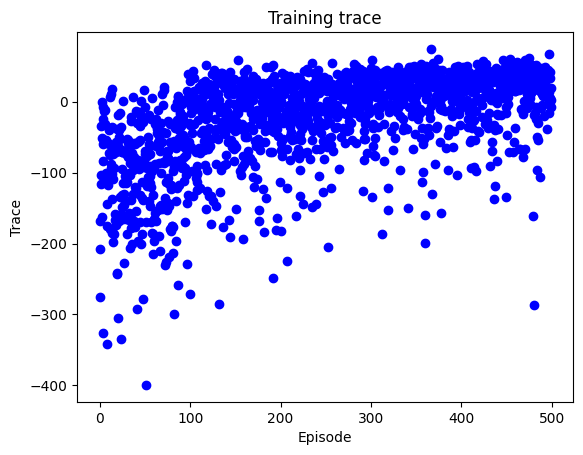

In [31]:

evaluation_trace_41 = np.loadtxt("ev_trace_41.csv", delimiter=",")
training_trace_41 = np.loadtxt("tr_trace_41.csv", delimiter=",")

plt.figure(2)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Evaluation reward')
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), np.mean(evaluation_trace_41, axis=1))

plt.figure(3)
plt.title('Training trace')
plt.xlabel('Episode')
plt.ylabel('Trace')
plt.scatter(range(500), training_trace_41[:, 0], c='b')
plt.scatter(range(500), training_trace_41[:, 1], c='b')
plt.scatter(range(500), training_trace_41[:, 2], c='b')


plt.show()

## Plot of an episode

In [41]:
seed=0 # change the seed to get another episode
# Get number of actions from gym action space
n_actions = 5
# Get the number of state observations
seed=seed+1
obs, info = env.reset(seed)
n_observations = np.prod(np.shape(obs))
agent2 = Deep_Q_Toggle(env, n_observations, n_actions)
str_epsilon="Var"
agent2.load_model("4" + str_epsilon+ "0")

seed=seed+1
random.seed(seed)

log=[]

finished=False
obs, info = env.reset(seed)
seed+=1
   
epsilon=0 
steps_done=0
while not finished:
        
    action = agent2.act(obs, epsilon)
    obs, r, finished, info = env.step(action.item())

    log.append(info) 

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    

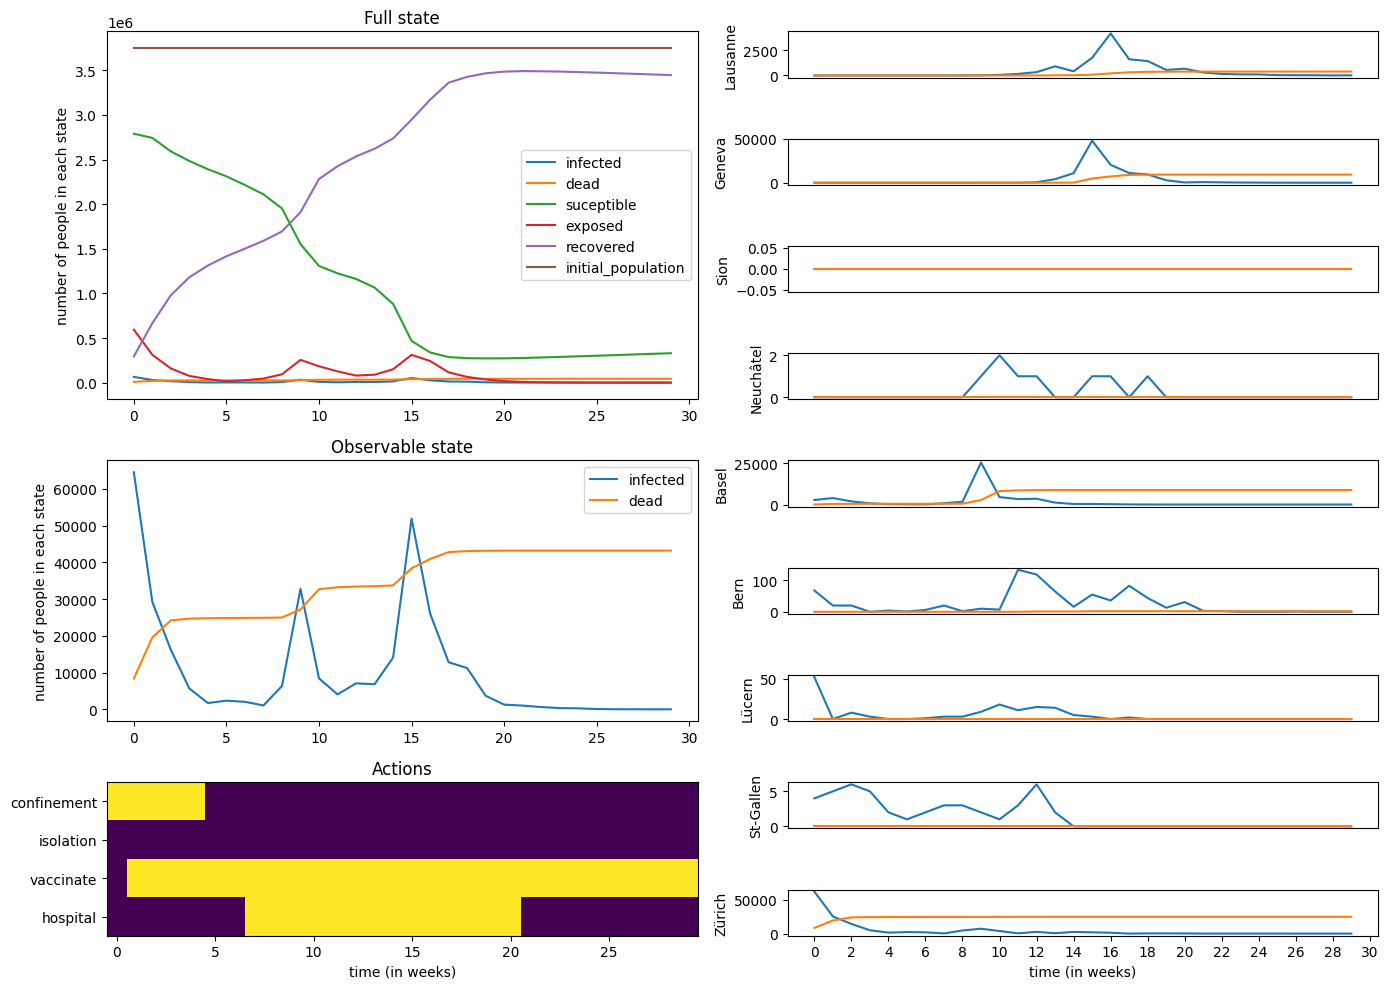

In [42]:
from matplotlib.ticker import MultipleLocator
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

In [ ]:
print(info.action.keys())

### Point 4.1.c.

In [43]:

seed=0 
# Get number of actions from gym action space
n_actions = 5
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))
agent2 = Deep_Q_Toggle(env, n_observations, n_actions)
str_epsilon="Var"
agent2.load_model("4" + str_epsilon+"0")

seed=seed+1
random.seed(seed)

# EVALUATION PROCEDURE
N= 50#
total_confinement=np.zeros(N)
rewards=np.zeros(N)
deaths=np.zeros(N)
##
seed=0

for n in range(N):
    finished=False
    obs, info = env.reset(seed)
    seed+=1
   
    epsilon=0 
    steps_done=0
    while not finished:
        
        action = agent2.act(obs, epsilon)
        obs, r, finished, info = env.step(action.item())

        if info.action["confinement"]==1:
            total_confinement[n]+=7
        rewards[n]+= r
        

    deaths[n]=info.total.dead 
    

### histograms

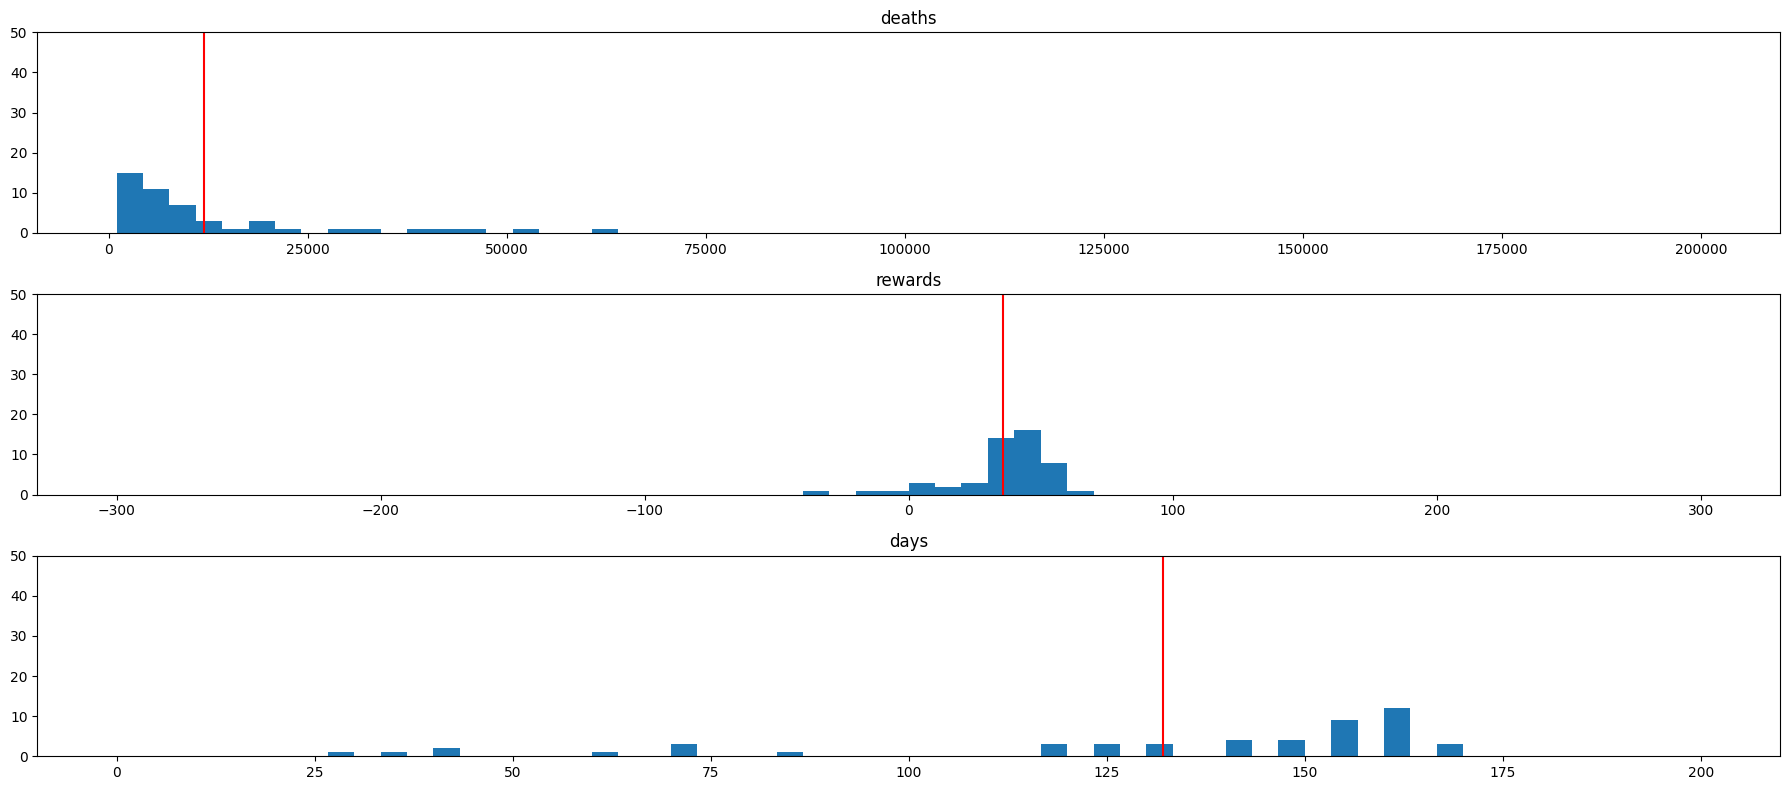

Average death number: 12042.1
Average rewards: 35.70223335266113
Average number of confined days: 132.16


In [44]:
""" Plot"""
fig, ax = plt.subplots(3,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'rewards')
hist_avg(ax[2], total_confinement,'days')
fig.tight_layout()
plt.show()

"""Print"""
print(f'Average death number: {np.mean(deaths)}')
print(f'Average rewards: {np.mean(rewards)}')
print(f'Average number of confined days: {np.mean(total_confinement)}')

## Q 4.2)  Factorized Q-values, multi-action agent

In [11]:
action_space        =   spaces.MultiBinary(4)   #
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


SCALE = 1

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    
    
    if a[0] == 1:
        action['confinement'] = True
    if a[1] == 1:
        action['isolation'] = True
    if a[2] == 1:
        action['vaccinate'] = True
    if a[3] == 1:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 1/4)
    dead = SCALE * np.power(np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 1/4)
    #confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)



env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

env_multi = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [12]:
import matplotlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

episode_deaths = []

def plot_deaths(show_result=False):
    plt.figure(1)
    deaths = torch.tensor(episode_deaths, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Deaths')
    plt.plot(deaths.numpy())
    # Take 100 episode averages and plot them too
    if len(deaths) >= 100:
        means = deaths.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())  

cpu


In [13]:
BATCH_SIZE = 2048
GAMMA = 0.9
TAU = 1
LR = 1e-3

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN_3(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_3, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 2*n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return torch.reshape(self.layer4(x), (-1, 4, 2))

In [14]:
class Deep_Q_Multi(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                n_observations,
                n_actions,
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.env = env
        self.policy_network=DQN_3(n_observations, n_actions)
        self.target_network=DQN_3(n_observations, n_actions)
        self.policy_network.to(device)
        self.target_network.to(device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(20000)
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.policy_network.load_state_dict(torch.load(savepath+'model_policy_weights.pth'))
        self.target_network.load_state_dict(torch.load(savepath+'model_target_weights.pth'))
        

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.policy_network.state_dict(), savepath+'model_policy_weights.pth')
        torch.save(self.target_network.state_dict(), savepath+'model_target_weights.pth')

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        global seed
        if len(self.memory) < BATCH_SIZE:
            return
        seed=seed+1
        random.seed(seed)
        transitions = self.memory.sample(BATCH_SIZE)
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        

        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        non_final_next_states = torch.reshape(non_final_next_states, (int(np.prod(np.shape(non_final_next_states))/self.n_observations), self.n_observations))
        #print(np.shape(batch.state))
        #print(np.shape(batch.action))
        batch_state = torch.zeros(BATCH_SIZE, self.n_observations)
        for i in range(BATCH_SIZE):
            batch_state[i, :]=torch.flatten(batch.state[i])
        state_batch = np.reshape(batch_state, (BATCH_SIZE, self.n_observations))
        action_batch = torch.cat(batch.action)
        action_batch = np.reshape(action_batch, (BATCH_SIZE, self.n_actions))
        reward_batch = torch.cat(batch.reward)
        #reward_batch = reward_batch.unsqueeze(1)
        #reward_batch = reward_batch.expand(BATCH_SIZE, 4)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        #print(np.shape(policy_net(state_batch)))
        #print(action_batch)
        #print("action_batch")
        #print(np.shape(action_batch)) # 256*4
        #print(np.shape(state_batch))
        #print(np.shape(self.policy_network(state_batch))) # 256*4*2
                
        state_action_values = torch.sum(self.policy_network(state_batch).gather(2, action_batch.unsqueeze(2)), dim=1)
        #print(np.shape(state_action_values))
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        #next_state_values = torch.zeros((BATCH_SIZE, self.n_actions), device=device)
        
        next_state_values = torch.zeros((BATCH_SIZE), device=device)
        #print(np.shape(self.target_network(non_final_next_states).max(2)[0]))
        with torch.no_grad():
            next_state_values[non_final_mask] = torch.sum(self.target_network(non_final_next_states).max(2)[0], dim=1)
        
        #print(np.shape(next_state_values[non_final_mask]))
        # Compute the expected Q values
        #print(np.shape(next_state_values))
        #print(np.shape(reward_batch))
        #print(np.shape(state_action_values))
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()
        return 0
    

    def init_weights(self, m):
        if type(m) == nn.Linear:
            m.weight.fill_(1.0)
    
    def reset(self, env):
        # This should be called when the environment is reset
        self.env = env
        self.memory = ReplayMemory(20000)
        self.policy_network=DQN_3(self.n_observations, self.n_actions).to(device)
        self.init_weights(self.policy_network)
        self.target_network=DQN_3(self.n_observations, self.n_actions).to(device)
        self.init_weights(self.target_network)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=LR, amsgrad=True)
        return 0
    
    def act(self, state, epsilon):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        global steps_done
        global seed
        state = torch.flatten(state)
        seed=seed+1
        random.seed(seed)
        sample = random.random() # TODO: Add seed
        steps_done += 1
        if sample > epsilon:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                #print(policy_net(state))
                big_Q=self.policy_network(state).reshape((4, 2))
                return torch.argmax(big_Q, dim=1)
        else:
            seed=seed+1
            random.seed(seed)
            env.action_space.seed(seed)
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

### Point 4.2.a.

In [ ]:
# Test cell

v = torch.zeros((1, 200))

torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
agent = Deep_Q_Multi(n_actions=4, n_observations=200, env=env)

n = agent.policy_network(v)
print(n)
k=n.reshape((4,2))
print(k)
s=k.argmax(dim=1)
print(s)
u=k.argmax(dim=1).view(4,1)
print(u)
print(s[2]==1)
print(u[2]==1)


In [ ]:
seed=0
# Get number of actions from gym action space
n_actions = 4
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))


num_episodes = 500
training_trace = np.zeros((num_episodes, 3))
evaluation_trace = np.zeros((int(num_episodes/50), 3))


seed = seed+1
random.seed(seed)
np.random.seed(seed)

seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
agent = Deep_Q_Multi(env, n_observations, n_actions)


episode_deaths = []

for n in range(3):
    del agent
    seed = seed+1
    env.reset(seed)
    seed=seed+1
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    agent = Deep_Q_Multi(env, n_observations, n_actions)
    agent.reset(env)
    
    #agent.load_model("initial")
    #agent = Deep_Q_Multi(env, n_observations, n_actions)
    
    k=0

    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        seed = seed+1
        state, info = env.reset(seed)
        #obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        #state = observation_preprocessor(obs, dyn)
        c_r=0
        ## For this point, epsilon is varying
        epsilon = np.maximum(0.7*(500-i_episode-1)/500, 0.2)
        str_epsilon = "Var_"
        steps_done=0
        for t in count():
            action = agent.act(state, epsilon)
            #print(action)
            #print(action.item())
            action=action.squeeze()
            observation, reward, done, infos = env.step(action)
            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            agent.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            agent.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            if done and (i_episode+1)%5==0:
                target_net_state_dict = agent.target_network.state_dict()
                policy_net_state_dict = agent.policy_network.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                agent.target_network.load_state_dict(target_net_state_dict)
            
            c_r = c_r + reward[0]
            if done:
                #episode_deaths.append(infos.total.dead)
                episode_deaths.append(c_r) # changed in order to see the reward and not the number of deaths
                ## Comment the next line to run the code faster
                #plot_deaths()
                training_trace[i_episode, n] = c_r
                if (i_episode+1)%10==0:
                    plot_deaths()
                break
            
        if (i_episode+1)%50==0:
            cum_rew = 0
            tmp_seed=seed
            seed=0
            
            for n_episode in range(20):
                seed=seed+1
                state, info = env.reset(seed)
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                cu = 0
                epsilon = 0
                steps_done=0
                for t in count():
                    action = agent.act(state, epsilon)
                    action = action.squeeze()
                    observation, reward, done, infos = env.step(action)
                    reward = torch.tensor([reward], device=device)

                    if done:
                        next_state = None
                    else:
                        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

                    # Store the transition in memory
                    #memory.push(state, action, next_state, reward)

                    # Move to the next state
                    state = next_state
                    cu = cu + reward[0] 
                    if done:
                        cum_rew = cum_rew+cu
                        break
            seed=tmp_seed
            evaluation_trace[k, n]=cum_rew/20
            k=k+1
    agent.save_model("42"+str_epsilon+str(n))
                

        


print('Complete')
plot_deaths(show_result=True)
plt.ioff()
plt.show()

### Evaluation and training traces

In [ ]:
plt.figure(4)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Trace')
plt.plot(np.linspace(50, num_episodes, len(evaluation_trace)), np.mean(evaluation_trace, axis=1))


plt.figure(5)
plt.title('Training trace')
plt.xlabel('Episode')
plt.ylabel('Trace')
plt.scatter(range(num_episodes), training_trace[:, 0], c='b')
plt.scatter(range(num_episodes), training_trace[:, 1], c='b')
plt.scatter(range(num_episodes), training_trace[:, 2], c='b')


plt.show()
print(evaluation_trace)

In [ ]:
evaluation_trace_42 = evaluation_trace
training_trace_42 = training_trace

np.savetxt("ev_trace_42.csv", evaluation_trace_42, delimiter=",")
np.savetxt("tr_trace_42.csv", training_trace_42, delimiter=",")


In [ ]:
evaluation_trace_42 = np.loadtxt("ev_trace_42.csv", delimiter=",")
training_trace_42 = np.loadtxt("tr_trace_42.csv", delimiter=",")

plt.figure(2)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Evaluation reward')
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), np.mean(evaluation_trace_41, axis=1), label="Toggle")
plt.plot(np.linspace(50, 500, len(evaluation_trace_42)), np.mean(evaluation_trace_42, axis=1), label = "Factor")
plt.legend()



plt.figure(3)
plt.title('Training trace')
plt.xlabel('Episode')
plt.ylabel('Trace')
plt.scatter(range(500), training_trace_41[:, 0], c='b', label ="Toggle")
plt.scatter(range(500), training_trace_41[:, 1], c='b')
plt.scatter(range(500), training_trace_41[:, 2], c='b')
plt.scatter(range(500), training_trace_42[:, 0], c='r', label="Factor")
plt.scatter(range(500), training_trace_42[:, 1], c='r')
plt.scatter(range(500), training_trace_42[:, 2], c='r')
plt.legend()

plt.figure(4)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Evaluation reward')
plt.plot(np.linspace(50, 500, len(evaluation_trace_42)), evaluation_trace_42[:, 0] )
plt.plot(np.linspace(50, 500, len(evaluation_trace_42)), evaluation_trace_42[:, 1] )
plt.plot(np.linspace(50, 500, len(evaluation_trace_42)), evaluation_trace_42[:, 2] )



plt.show()

### Plot of an episode

In [ ]:
seed=0 # change the seed to get another episode
# Get number of actions from gym action space
n_actions = 4
# Get the number of state observations
seed=seed+1
obs, info = env.reset(seed)
n_observations = np.prod(np.shape(obs))
agent2 = Deep_Q_Multi(env, n_observations, n_actions)
str_epsilon="Var_"
agent2.load_model("42" + str_epsilon+"0")

seed = seed+1
random.seed(seed)

log=[]
##


finished = False
seed+=1   
epsilon = 0
steps_done=0
    
while not finished:
    action = agent2.act(obs, epsilon)
    obs, r, finished, info = env.step(action)
        
    log.append(info)
    
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

In [ ]:
from matplotlib.ticker import MultipleLocator

cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('time (in weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

## Point 4.2.b.

In [15]:
seed=0
# Get number of actions from gym action space
n_actions = 4
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))
agent2 = Deep_Q_Multi(env, n_observations, n_actions)
str_epsilon="Var_"
agent2.load_model("42" + str_epsilon+"0")

seed = seed+1
random.seed(seed)

# EVALUATION PROCEDURE
N= 50 
total_confinement=np.zeros(N)
rewards=np.zeros(N)
deaths=np.zeros(N)
##
seed=0

for n in range(N):
    finished = False
    obs, info = env.reset(seed)
    seed+=1#####
    
    epsilon = 0
    steps_done=0
    while not finished:
        action = agent2.act(obs, epsilon)
        obs, r, finished, info = env.step(action)
        
       
        if info.action["confinement"]==1:
            total_confinement[n]+=7
        
        rewards[n]+= r
        
    deaths[n]=info.total.dead 
    

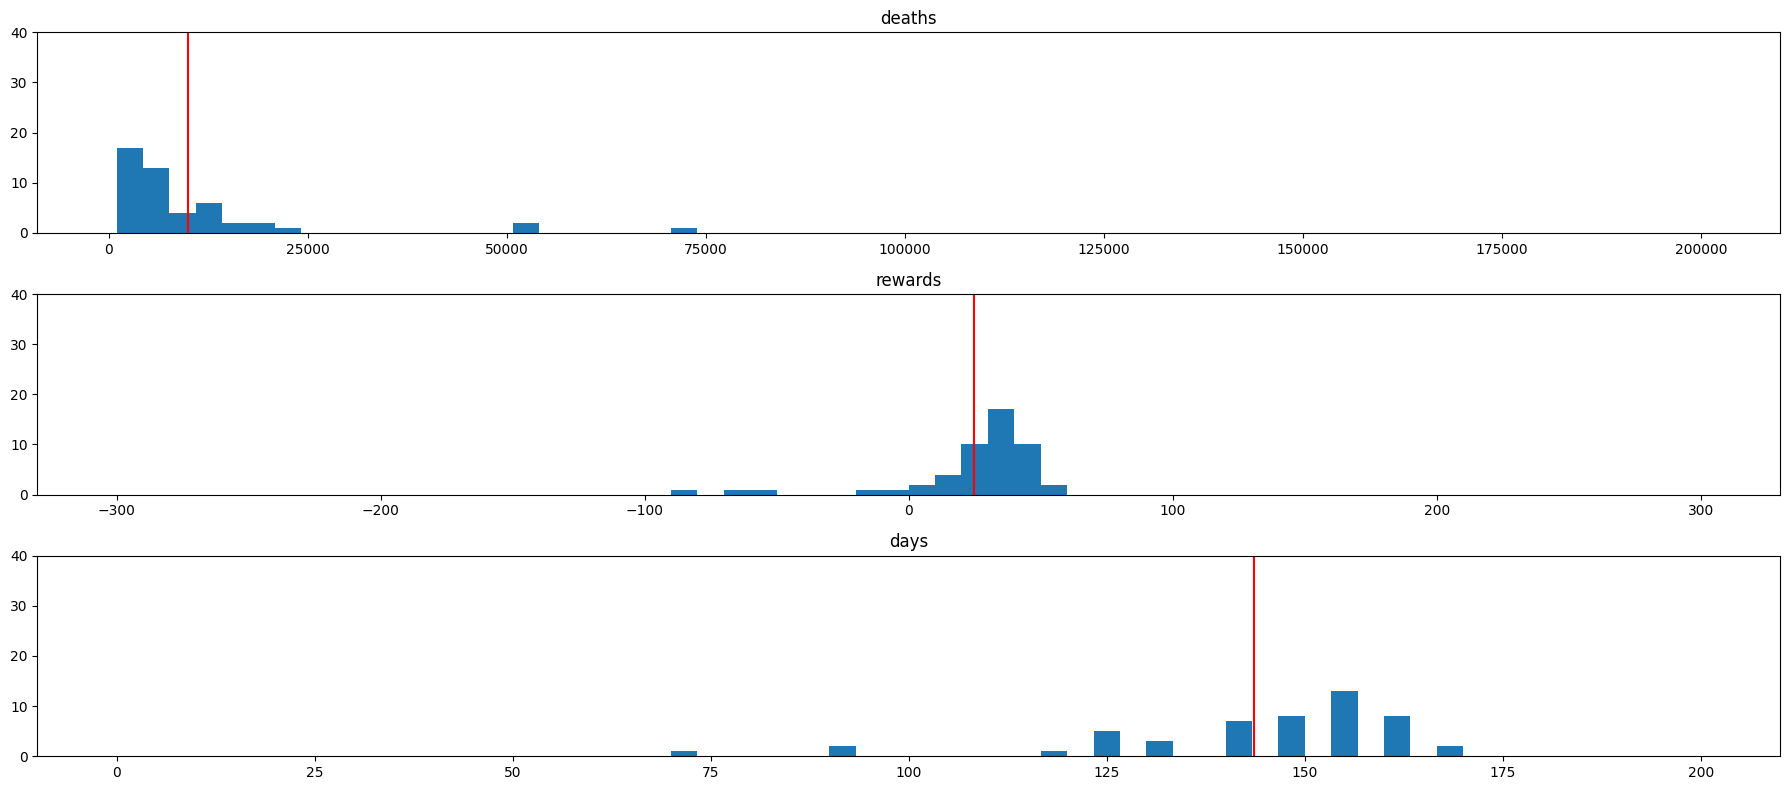

Average death number: 9924.48
Average reward: 24.89776870727539
Average number of isolation days: 143.64


In [16]:
""" Plot"""
fig, ax = plt.subplots(3,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 40
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'rewards')
hist_avg(ax[2], total_confinement,'days')
fig.tight_layout()
plt.show()

"""Print"""
print(f'Average death number: {np.mean(deaths)}')
print(f'Average reward: {np.mean(rewards)}')
print(f'Average number of isolation days: {np.mean(total_confinement)}')

# Q5

## Point 5a

In [45]:
# Comparison of the evaluation trace

evaluation_trace_3a = np.loadtxt("ev_trace_3a.csv", delimiter=",")
evaluation_trace_3b = np.loadtxt("ev_trace_3b.csv", delimiter=",")
evaluation_trace_41 = np.loadtxt("ev_trace_41.csv", delimiter=",")
evaluation_trace_42 = np.loadtxt("ev_trace_42.csv", delimiter=",")

plt.figure(1)
plt.title('Evaluation trace')
plt.xlabel('Episode')
plt.ylabel('Evaluation reward')
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), -73*np.ones(len(evaluation_trace_41)), label="Russo")
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), np.mean(evaluation_trace_3a, axis=1), label="$\pi_{DQN}$, $\epsilon$ constant")
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), np.mean(evaluation_trace_3b, axis=1), label="$\pi_{DQN}$, $\epsilon$ varying")
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), np.mean(evaluation_trace_41, axis=1), label="$\pi_{toggle}$")
plt.plot(np.linspace(50, 500, len(evaluation_trace_41)), np.mean(evaluation_trace_42, axis=1), label="$\pi_{factor}$")
plt.legend()


## Point 5b.

15075
41
221
141
127
17761
6045
1270
240
162
1137
368
631
4093
271
400
5819
6054
1904
3707
61
1756
175
7064
1268
1808
7375
2742
2852
119
5235
557
2529
197
2870
384
222
6351
3325
86
4098
150
9389
705
26
5919
1608
4806
540
101


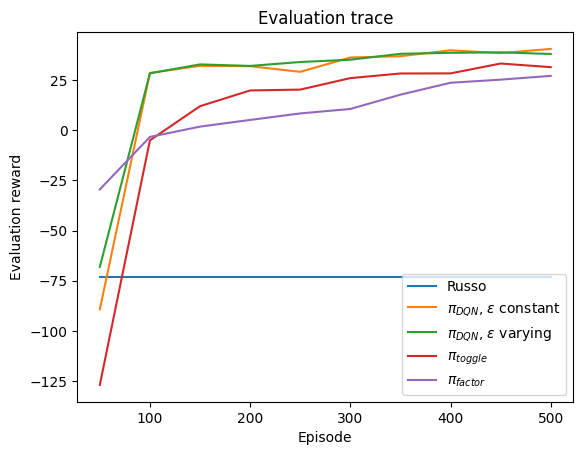

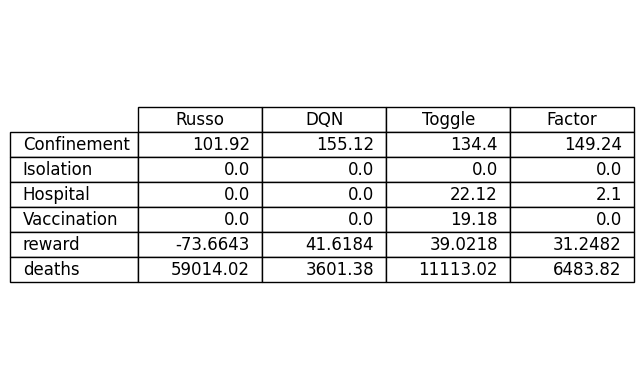

In [46]:
# Russo
agent_Russo = Russo(env_russo) # definition of the policy

# DQN
seed=0
# Get number of actions from gym action space
n_actions = 2
# Get the number of state observations
seed=seed+1
state, info_DQN = env_DQN.reset(seed)
n_observations = np.prod(np.shape(state))
agent_DQN = Deep_Q(env_DQN, n_observations, n_actions)
str_epsilon="Cst"
agent_DQN.load_model("3" + str_epsilon+"0")

seed = seed+1

# Toggle
# Get number of actions from gym action space
n_actions = 5
# Get the number of state observations
seed=seed+1
state, info_toggle = env_toggle.reset(seed)
n_observations = np.prod(np.shape(state))
agent_toggle = Deep_Q_Toggle(env_toggle, n_observations, n_actions)
str_epsilon="Var"
agent_toggle.load_model("4" + str_epsilon+"0")

seed=seed+1

# factor
# Get number of actions from gym action space
n_actions = 4
# Get the number of state observations
seed=seed+1
state, info_factor = env_multi.reset(seed)
n_observations = np.prod(np.shape(state))
agent_factor = Deep_Q_Multi(env_multi, n_observations, n_actions)
str_epsilon="Var_"
agent_factor.load_model("42" + str_epsilon+"0")

seed = seed+1
random.seed(seed)

# EVALUATION PROCEDURE 

N= 50
total_confinement=np.zeros((4,N))
total_isolation=np.zeros((4,N))
total_vaccination=np.zeros((4,N))
total_hospital=np.zeros((4,N))
rewards=np.zeros((4,N))
deaths=np.zeros((4,N))
seed=0
for n in range(N):
    
    finished = False
    obs, info = env_russo.reset(seed)
    agent_Russo.reset(env_russo)
    
    seed+=1
    agent_Russo.epsilon = 0

    #Russo
    while not finished:
        
        action_Russo=agent_Russo.act(info)
 
        obs, r, finished, info = env_russo.step(action_Russo)
        
        if info.action["confinement"]==1:
            total_confinement[0,n]+=7
        elif info.action["isolation"]==1:
            total_isolation[0,n]+=7
        elif info.action["hospital"]==1:
            total_hospital[0,n]+=7
        elif info.action["vaccinate"]==1:
            total_vaccination[0,n]+=7
        
        rewards[0,n]+=r
        
    deaths[0,n]=info.total.dead 
    
     # DQN
    finished =False
    obs, info_DQN = env_DQN.reset(seed)
    seed+=1
    print(info_DQN.total.infected)

    epsilon = 0    
    steps_done=0
    while not finished:
        action_DQN = agent_DQN.act(obs, epsilon)
        obs, r, finished, info_DQN = env_DQN.step(action_DQN.item())        
    
        if info_DQN.action["confinement"]==1:
            total_confinement[1,n]+=7
        elif info_DQN.action["isolation"]==1:
            total_isolation[1,n]+=7
        elif info_DQN.action["hospital"]==1:
            total_hospital[1,n]+=7
        elif info_DQN.action["vaccinate"]==1:
            total_vaccination[1,n]+=7
            
        rewards[1,n]+=r
        
    deaths[1,n]=info_DQN.total.dead 
    
    # Toggle
    finished=False
    obs, info_toggle = env_toggle.reset(seed)
    seed+=1
   
    while not finished:
        
        action_toggle = agent_toggle.act(obs, epsilon)
        obs, r, finished, info_toggle = env_toggle.step(action_toggle.item())
        
        if info_toggle.action["confinement"]==1:
            total_confinement[2,n]+=7
        elif info_toggle.action["isolation"]==1:
            total_isolation[2,n]+=7
        elif info_toggle.action["hospital"]==1:
            total_hospital[2,n]+=7
        elif info_toggle.action["vaccinate"]==1:
            total_vaccination[2,n]+=7
        
        rewards[2,n]+=r
        
    deaths[2,n]=info_toggle.total.dead 
    
    # factor
    
    finished = False
    obs, info_factor = env_multi.reset(seed)
    seed+=1 
 
    
    while not finished:
        action_factor = agent_factor.act(obs, epsilon)
        obs, r, finished, info_factor = env_multi.step(action_factor)
        
       
        if info_factor.action["confinement"]==1:
            total_confinement[3,n]+=7
        elif info_factor.action["isolation"]==1:
            total_isolation[3,n]+=7
        elif info_factor.action["hospital"]==1:
            total_hospital[3,n]+=7
        elif info_factor.action["vaccinate"]==1:
            total_vaccination[3,n]+=7
        
        rewards[3,n]+=r
        
    deaths[3,n]=info_factor.total.dead 
    
    
col_labels = ['Russo', 'DQN', 'Toggle','Factor']
row_labels = ['Confinement', 'Isolation', 'Hospital','Vaccination','reward','deaths']
data = np.zeros((len(row_labels),len(col_labels)))  

data[0,:]=np.mean(total_confinement,axis=1)
data[1,:]=np.mean(total_isolation,axis=1)
data[2,:]=np.mean(total_hospital,axis=1)
data[3,:]=np.mean(total_vaccination,axis=1)
data[4,:]=np.mean(rewards,axis=1)
data[5,:]=np.mean(deaths,axis=1)
data[4,:]=np.round(data[4,:],4)
fig, ax = plt.subplots()
ax.axis('off')  

table = ax.table(cellText=data, colLabels=col_labels, rowLabels=row_labels, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  

plt.show()

# 5.c

In [ ]:
## Load \pi DQN
# Before running this part, please run the cells of point 3, until (and without) training

seed=0
# Get number of actions from gym action space
n_actions = 2

seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))
agent = Deep_Q(env, n_observations, n_actions)
str_epsilon="Var"
agent.load_model("3" + str_epsilon+"0")

seed = seed+1
random.seed(seed)

seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# 
N= 1
total_confinement=np.zeros(N)
rewards=np.zeros(N)
deaths=np.zeros(N)
##
seed=seed+1
state,info=env.reset(seed)
seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
seed=seed+1

for n in range(N):
    log = []
    day=0
    seed+=1
    state, info = env.reset(seed)
    
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    Q_values = torch.zeros((30, 2))
    
    epsilon = 0
    
 
    steps_done=0
    for t in count():
        day=day+1
        action = agent.act(state, epsilon)
        observation, reward, done, info = env.step(action.item())
        Q_values[t, :] = agent.policy_network(torch.flatten(state))
        
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state


        rewards[n]+= reward
        if action==1:
            total_confinement[n]+=7
        log.append(info) # save the information dict for logging
        if done:
            break
        
    deaths[n]=info.total.dead 
    

    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}


name = ['not confine', 'confine']



fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)
cax = ax.matshow(Q_values.T.detach())
fig.colorbar(cax)

xaxis = np.arange(len(name))
ax.set_yticks(xaxis)
ax.set_yticklabels(name)
ax.set_xticks(np.arange(30))
ax.set_xticklabels(np.arange(30))
ax.set_xlabel('Week')
ax.set_ylabel('Q-values')

plt.show()



In [ ]:
# Load \pi multi
# Before running this part, please run the cells of point 4.2, until (and without) training

seed=1
# Get number of actions from gym action space
n_actions = 4
# Get the number of state observations
seed=seed+1
state, info = env.reset(seed)
n_observations = np.prod(np.shape(state))
agent = Deep_Q_Multi(env, n_observations, n_actions)
str_epsilon="Var_"
agent.load_model("42" + str_epsilon+"0")

seed = seed+1
random.seed(seed)

seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# 
N= 1
total_confinement=np.zeros(N)
rewards=np.zeros(N)
deaths=np.zeros(N)
##
seed=seed+1
state,info=env.reset(seed)
seed=seed+1
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
seed=seed+1


for n in range(N):
    log = []
    day=0
    seed+=1
    state, info = env.reset(seed)
    
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    Q_values = torch.zeros((30, 8))

    epsilon = 0

 
    steps_done=0
    for t in count():
        day=day+1
        action = agent.act(state, epsilon)
        observation, reward, done, info = env.step(action)
        Q_values[t, :] = torch.flatten(agent.policy_network(torch.flatten(state)))
        
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state


        rewards[n]+= reward
        if action[0]==1:
            total_confinement[n]+=7
        log.append(info) # save the information dict for logging
        if done:
            break
        
        
    deaths[n]=info.total.dead 
    
    #
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

name = ['not confine', 'confine', 'not isolate', 'isolate', 'not vaccinate', 'vaccinate', 'not hospital', 'hospital']



fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
cax = ax.matshow(Q_values.T.detach())
fig.colorbar(cax)

xaxis = np.arange(len(name))
ax.set_yticks(xaxis)
ax.set_yticklabels(name)
ax.set_xticks(np.arange(30))
ax.set_xticklabels(np.arange(30))
ax.set_xlabel('Week')
ax.set_ylabel('Q-values')

plt.show()